# Data transformation


In [273]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
# always reload modules marked with "%aimport"
%autoreload 1

In [275]:
import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, os.pardir,'src')
sys.path.append(src_dir)

%aimport features.helpers
from features.helpers import load_data
from features.helpers import save_data
from features.helpers import norm_data
from features.helpers import encode_cat_data
from features.helpers import set_index_to_date
from features.helpers import save_pandas
from features.helpers import plot_data
from features.helpers import MultiColumnLabelEncoder
from datetime import datetime
import pandas as pd
from pandas import DataFrame
from pandas import concat


In [276]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
# Set context to `"paper"`
sns.set_context("paper", font_scale=2)

In [277]:
# convert string into a date object
import time
import datetime as dt
from datetime import datetime

def dateconvert(Start_date):
    try:
        Start_date = int(Start_date)  
        Date_String = str(Start_date)
        dateconv = dt.datetime.strptime(Date_String,'%YYYY-%mm-%dd').strftime('%d/%m/%Y')
        return  dateconv
    except ValueError:
        return Start_date #or '' or whatever you want to return for NULL

In [278]:
processed_dir = os.path.join(os.getcwd(),os.pardir, os.pardir,'data')
input_filepath = processed_dir + "/processed/001-BB-CDC_ILI_2010-2015_US_STATES-DATA_processed.csv"
output_filepath = processed_dir + "/interim/001-BB-CDC_ILI_2010-2015_US_STATES-DATA_interim.pickle"

#load stored data
%store -r preprocess_data
%store -r group_df
%store -r ili_h1
#df = load_data(input_filepath)

## At what is the best temperature for influenza 

In [279]:
df = ili_h1
df = df.dropna(how='any')
cols_to_drop = ['index','week_TEMP']
df.drop(cols_to_drop, 1, inplace=True)
df.head()

,STATE,YEAR,MONTH,WEEK,ili_activity_label,a_h1,Latitude,Longitude
0,AK,2011,1,1,Level 1,0,61.370716,-152.404419
1,AK,2011,1,2,Level 2,0,61.370716,-152.404419
2,AK,2011,1,3,Level 3,0,61.370716,-152.404419
3,AK,2011,1,4,Level 2,0,61.370716,-152.404419
4,AK,2011,1,5,Level 5,0,61.370716,-152.404419


## LSTM Data Preparation

In [280]:
#df = MultiColumnLabelEncoder(columns = ['STATE','ili_activity_label','lat_label', 'temp_group']).fit_transform(df)

In [281]:
df.values[:,0]

array(['AK', 'AK', 'AK', ..., 'WY', 'WY', 'WY'], dtype=object)

In [282]:
df.values[:,1]

array([2011, 2011, 2011, ..., 2015, 2015, 2015], dtype=object)

In [283]:
df.values[:,2]

array([1, 1, 1, ..., 5, 5, 5], dtype=object)

In [284]:
df.values[:,3]

array([1, 2, 3, ..., 19, 20, 21], dtype=object)

In [285]:
df.values[:,4]

array(['Level 1', 'Level 2', 'Level 3', ..., 'Level 1', 'Level 1',
       'Level 1'], dtype=object)

In [286]:
df.values[:,5]

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [287]:
df.values[:,6]

array([61.370716, 61.370716, 61.370716, ..., 42.755966, 42.755966,
       42.755966], dtype=object)

In [288]:
df.values[:,7]

array([-152.404419, -152.404419, -152.404419, ..., -107.30248999999999,
       -107.30248999999999, -107.30248999999999], dtype=object)

In [305]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [290]:
df.head()

,STATE,YEAR,MONTH,WEEK,ili_activity_label,a_h1,Latitude,Longitude
0,AK,2011,1,1,Level 1,0,61.370716,-152.404419
1,AK,2011,1,2,Level 2,0,61.370716,-152.404419
2,AK,2011,1,3,Level 3,0,61.370716,-152.404419
3,AK,2011,1,4,Level 2,0,61.370716,-152.404419
4,AK,2011,1,5,Level 5,0,61.370716,-152.404419


In [291]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# load dataset
dataset = df
values = dataset.values

In [292]:
# integer encode direction
encoder = LabelEncoder()
# encode STATE
values[:,0] = encoder.fit_transform(values[:,0])
# encode ili_activity_label
values[:,4] = encoder.fit_transform(values[:,4])


In [293]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
DataFrame(scaled).head()

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.000000,0.1,0.0,1.0,0.057809
1,0.0,0.0,0.0,0.019231,0.3,0.0,1.0,0.057809
2,0.0,0.0,0.0,0.038462,0.4,0.0,1.0,0.057809
3,0.0,0.0,0.0,0.057692,0.3,0.0,1.0,0.057809
4,0.0,0.0,0.0,0.076923,0.6,0.0,1.0,0.057809


In [1]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,13,14,15]], axis=1, inplace=True)
# we are predicting ili activity
%store reframed
reframed.head()

NameError: name 'series_to_supervised' is not defined

## Define and Fit Model

In [295]:
# split into train and test sets
values = reframed.values
n_train_weeks = 5*20*52

In [296]:
train = values[:n_train_weeks, :]
test = values[n_train_weeks:, :]

In [297]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [298]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((5200, 1, 8), (5200,), (5938, 1, 8), (5938,))


## Design Network

Train on 5200 samples, validate on 5938 samples
Epoch 1/50
 - 2s - loss: 0.1241 - val_loss: 0.1002
Epoch 2/50
 - 0s - loss: 0.1031 - val_loss: 0.0882
Epoch 3/50
 - 0s - loss: 0.0842 - val_loss: 0.0719
Epoch 4/50
 - 0s - loss: 0.0666 - val_loss: 0.0637
Epoch 5/50
 - 0s - loss: 0.0662 - val_loss: 0.0621
Epoch 6/50
 - 0s - loss: 0.0584 - val_loss: 0.0604
Epoch 7/50
 - 0s - loss: 0.0581 - val_loss: 0.0586
Epoch 8/50
 - 0s - loss: 0.0589 - val_loss: 0.0642
Epoch 9/50
 - 0s - loss: 0.0560 - val_loss: 0.0558
Epoch 10/50
 - 0s - loss: 0.0581 - val_loss: 0.0619
Epoch 11/50
 - 0s - loss: 0.0557 - val_loss: 0.0558
Epoch 12/50
 - 0s - loss: 0.0577 - val_loss: 0.0547
Epoch 13/50
 - 0s - loss: 0.0577 - val_loss: 0.0592
Epoch 14/50
 - 0s - loss: 0.0562 - val_loss: 0.0562
Epoch 15/50
 - 0s - loss: 0.0559 - val_loss: 0.0572
Epoch 16/50
 - 0s - loss: 0.0553 - val_loss: 0.0547
Epoch 17/50
 - 0s - loss: 0.0553 - val_loss: 0.0557
Epoch 18/50
 - 0s - loss: 0.0572 - val_loss: 0.0601
Epoch 19/50
 - 0s - loss:

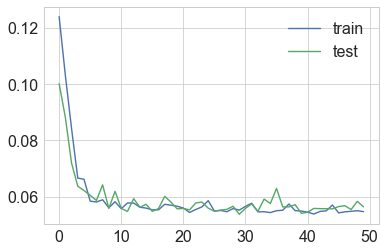

In [299]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluate Model

In [300]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [301]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
DataFrame(inv_yhat).head()

,0,1,2,3,4,5,6,7
0,0.099595,0.0,0.545455,0.500000,0.1,0.0,0.431066,0.740043
1,0.099768,0.0,0.545455,0.519231,0.1,0.0,0.431066,0.740043
2,0.099940,0.0,0.545455,0.538462,0.1,0.0,0.431066,0.740043
3,0.100112,0.0,0.545455,0.557692,0.1,0.0,0.431066,0.740043
4,0.100283,0.0,0.545455,0.576923,0.1,0.0,0.431066,0.740043


In [302]:
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
DataFrame(inv_yhat).head()

,0
0,4.481761
1,4.489551
2,4.497311
3,4.505041
4,4.512741


In [303]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
DataFrame(inv_yhat).head()

,0
0,4.481761
1,4.489551
2,4.497311
3,4.505041
4,4.512741


In [304]:
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.054


## Tuning